In [2]:
import copy
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import torch
import torch.optim as optim

In [66]:
lat_lon_resolution = [4,4]
mm_cond_number = 10
params= [20, 8.25, 5.25, 0.2, 0.5, 5]
# params= [20, 8.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 8


# Load the one dictionary to set spaital coordinates
# filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"
filepath = "/Users/joonwonlee/Documents/GEMS_DATA/pickle_2023/coarse_cen_map23_01.pkl"
with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        # filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        filepath = f"/Users/joonwonlee/Documents/GEMS_DATA/pickle_{year}/coarse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= [0, 8]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


In [67]:
def matern_cov_yx2( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U= coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out


def full_likelihood( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)

    return log_det, quad_form, neg_log_lik    

# logdet, quad, nll = full_likelihood(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx2)
   
nll

tensor(2683.9910)

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

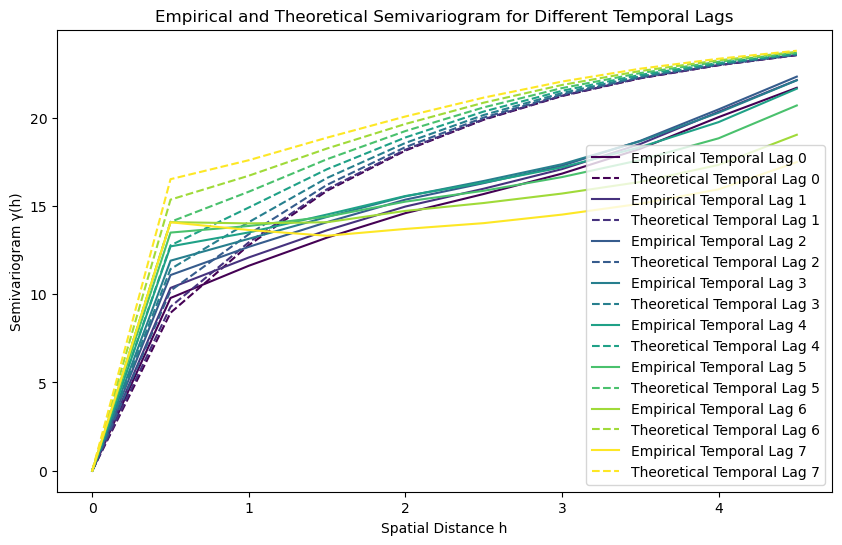

In [68]:
def empirical_semivariogram(data, max_distance, num_bins, temporal_lag):
    # Extract spatial and temporal coordinates and values
    lat = data[:, 0]
    lon = data[:, 1]
    ozone = data[:, 2]
    time = data[:, 3]

    # Convert to PyTorch tensors
    lat = torch.tensor(lat)
    lon = torch.tensor(lon)
    ozone = torch.tensor(ozone)
    time = torch.tensor(time)

    # Calculate pairwise distances
    spatial_distances = torch.sqrt((lat[:, None] - lat[None, :])**2 + (lon[:, None] - lon[None, :])**2)
    temporal_distances = torch.abs(time[:, None] - time[None, :])
    
    # Calculate semivariances
    semivariances = 0.5 * (ozone[:, None] - ozone[None, :])**2

    # Bin the distances
    bins = torch.linspace(0, max_distance, num_bins + 1)
    bin_indices = torch.bucketize(spatial_distances, bins) - 1

    # Calculate empirical semivariogram for the given temporal lag
    empirical_gamma = torch.zeros(num_bins)
    for i in range(num_bins):
        # Mask for spatial distance in bin i and specific temporal lag
        mask = (bin_indices == i) & (temporal_distances == temporal_lag)
        if torch.any(mask):
            empirical_gamma[i] = torch.mean(semivariances[mask])
    
    # Explicitly handle spatial lag of 0, which should always be 0
    empirical_gamma[0] = 0.0

    return bins[:-1], empirical_gamma


def theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag):
    # Calculate pairwise distances
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]

    lat = torch.tensor(lat)
    lon = torch.tensor(lon)
    time = torch.tensor(time)

    spatial_distances = torch.sqrt((lat[:, None] - lat[None, :])**2 + (lon[:, None] - lon[None, :])**2)
    temporal_distances = torch.abs(time[:, None] - time[None, :])

    # Bin the distances
    bins = torch.linspace(0, max_distance, num_bins + 1)
    bin_indices = torch.bucketize(spatial_distances, bins) - 1

    # Calculate covariance matrix
    cov_matrix = matern_cov_yx2(params, data, data)

    # Calculate theoretical semivariogram for the given temporal lag
    theoretical_gamma = torch.zeros(num_bins)
    for i in range(num_bins):
        # Mask for spatial distance in bin i and specific temporal lag
        mask = (bin_indices == i) & (temporal_distances == temporal_lag)
        if torch.any(mask):
            theoretical_gamma[i] = params[0] - torch.mean(cov_matrix[mask])  # params[0] is sigmasq
    
    # Explicitly handle spatial lag of 0, which should always be 0
    theoretical_gamma[0] = 0.0

    return bins[:-1], theoretical_gamma


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
params = torch.tensor([25.3, 1.78, 1.78, -0.042, .238, 2.85])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()


/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1437601678.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1437601678.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1437601678.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194w

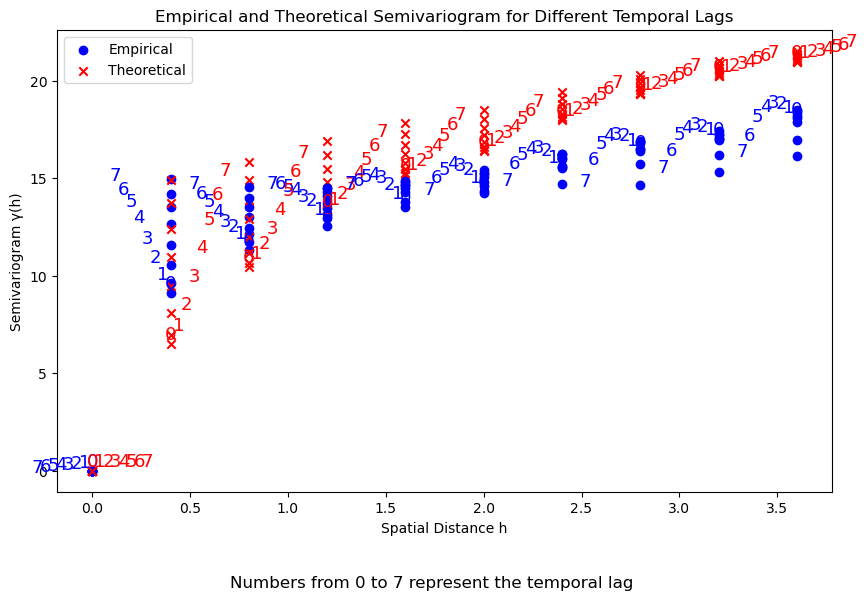

In [56]:
def empirical_semivariogram(data, max_distance, num_bins, temporal_lag):
    # Extract spatial and temporal coordinates and values
    lat = data[:, 0]
    lon = data[:, 1]
    ozone = data[:, 2]
    time = data[:, 3]

    # Convert to PyTorch tensors
    lat = torch.tensor(lat)
    lon = torch.tensor(lon)
    ozone = torch.tensor(ozone)
    time = torch.tensor(time)

    # Calculate pairwise distances
    spatial_distances = torch.sqrt((lat[:, None] - lat[None, :])**2 + (lon[:, None] - lon[None, :])**2)
    temporal_distances = torch.abs(time[:, None] - time[None, :])
    
    # Calculate semivariances
    semivariances = 0.5 * (ozone[:, None] - ozone[None, :])**2

    # Bin the distances
    bins = torch.linspace(0, max_distance, num_bins + 1)
    bin_indices = torch.bucketize(spatial_distances, bins) - 1

    # Calculate empirical semivariogram for the given temporal lag
    empirical_gamma = torch.zeros(num_bins)
    
    for i in range(num_bins):
        mask = (bin_indices == i) & (temporal_distances == temporal_lag)
        if torch.any(mask):
            empirical_gamma[i] = torch.mean(semivariances[mask])

    # Explicitly set the semivariogram at spatial lag 0 to 0
    empirical_gamma[0] = 0  # This ensures that the semivariogram at spatial lag 0 is 0.

    return bins[:-1], empirical_gamma


def matern_cov_yx2(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2

    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(-torch.sqrt(distance[non_zero_indices]) / range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

def theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag):
    # Calculate pairwise distances
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]

    lat = torch.tensor(lat)
    lon = torch.tensor(lon)
    time = torch.tensor(time)

    spatial_distances = torch.sqrt((lat[:, None] - lat[None, :])**2 + (lon[:, None] - lon[None, :])**2)
    temporal_distances = torch.abs(time[:, None] - time[None, :])

    # Bin the distances
    bins = torch.linspace(0, max_distance, num_bins + 1)
    bin_indices = torch.bucketize(spatial_distances, bins) - 1

    # Calculate covariance matrix
    cov_matrix = matern_cov_yx2(params, data, data)

    # Calculate theoretical semivariogram for the given temporal lag
    theoretical_gamma = torch.zeros(num_bins)
    
    for i in range(num_bins):
        mask = (bin_indices == i) & (temporal_distances == temporal_lag)
        if torch.any(mask):
            theoretical_gamma[i] = params[0] - torch.mean(cov_matrix[mask])  # params[0] is sigmasq

    # Explicitly set the semivariogram at spatial lag 0 to 0
    theoretical_gamma[0] = 0  # This ensures that the semivariogram at spatial lag 0 is 0.

    return bins[:-1], theoretical_gamma


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance =  4
num_bins = 10

# Define parameters for the theoretical semivariogram
params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    # Plot empirical semivariogram
    plt.scatter(bins.numpy(), empirical_gamma.numpy(), marker='o', color='blue')
    for j, (x, y) in enumerate(zip(bins, empirical_gamma)):
        if j >= 0:
            plt.text(x - 0.04 * temporal_lag, y - 0.04 * temporal_lag , str(temporal_lag), fontsize=13, color='blue', ha='center', va='bottom')
    
    # Plot theoretical semivariogram
    plt.scatter(bins.numpy(), theoretical_gamma.numpy(), marker='x', color='red')
    for j, (x, y) in enumerate(zip(bins, theoretical_gamma)):
        if j >= 0:
            plt.text(x + 0.04 * temporal_lag, y, str(temporal_lag), fontsize=13, color='red', ha='center', va='bottom')

# Add a simple legend
plt.scatter([], [], marker='o', color='blue', label='Empirical')
plt.scatter([], [], marker='x', color='red', label='Theoretical')
plt.legend()

# Add a caption
plt.figtext(0.5, -0.05, 'Numbers from 0 to 7 represent the temporal lag', ha='center', fontsize=12)

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.show()

day2 

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/3668564536.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

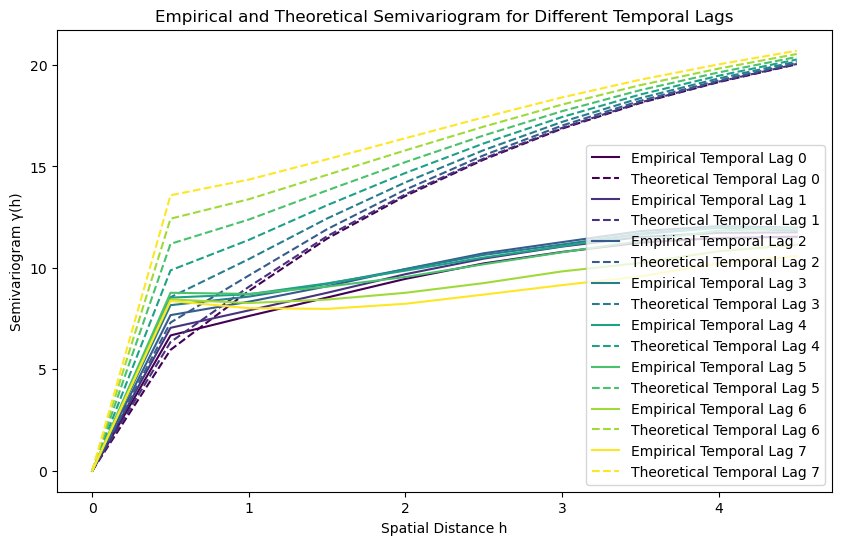

In [69]:

key_for_dict= [8, 16]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
# params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
params = torch.tensor([23.59, 3.83, 3.83, 0.036, 0.277, 2.83  ]) 
params = torch.tensor([24.56, 2.80, 2.80, -0.0138, .301, 2.12  ]) 

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()

day3 

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/4198474054.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/2603726844.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/2603726844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

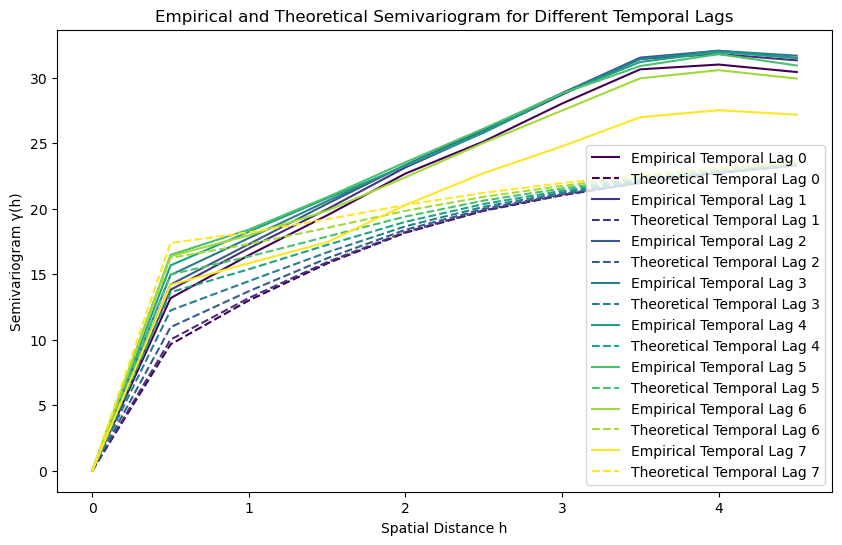

In [65]:
key_for_dict= [16, 24]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
# params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
# params = torch.tensor([23.59, 3.83, 3.83, 0.036, 0.277, 2.83  ]) 
params = torch.tensor([24.91, 1.73, 1.73, -0.056, .259, 3.57 ]) 

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()